In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
import torch
import config

In [2]:
from dataset import Apex
dataset = Apex(config.Apex_PATH)

result_path = os.path.join(config.RESULTS_PATH, 'apex')

# Ground Truth

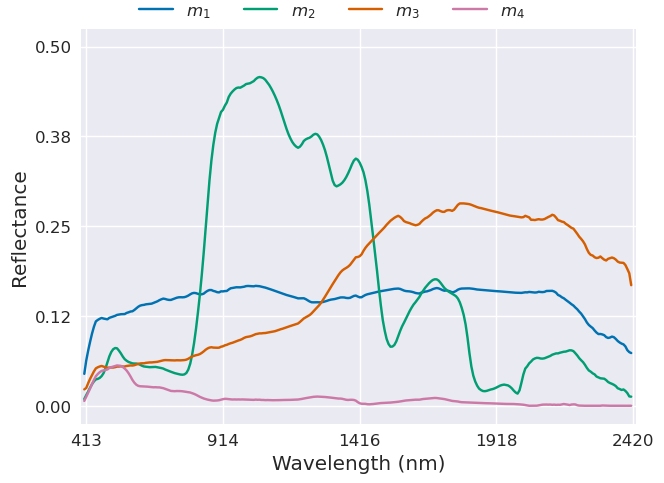

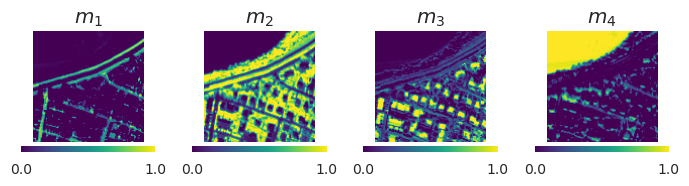

In [3]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), np.array(dataset.wv), ticks_range=(0, .5), n_ticks=5)
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [4]:
dataset.endmembers().shape, dataset.wv.shape

(torch.Size([4, 285]), (285,))

In [5]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

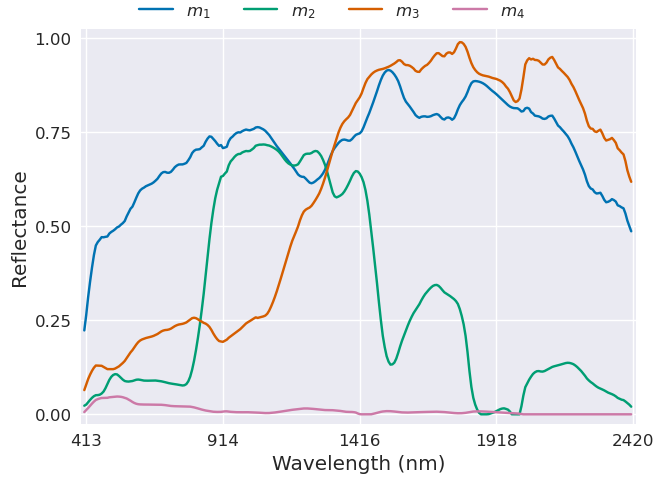

In [6]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=20, random_state=42)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, dataset.wv, ticks_range=(0, 1))
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

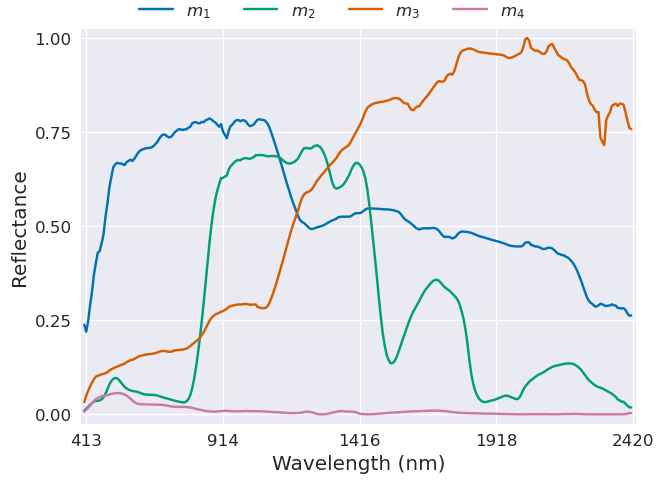

In [7]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_endmember_init = endmember[e_idx]
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-nfindr_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, dataset.wv, ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

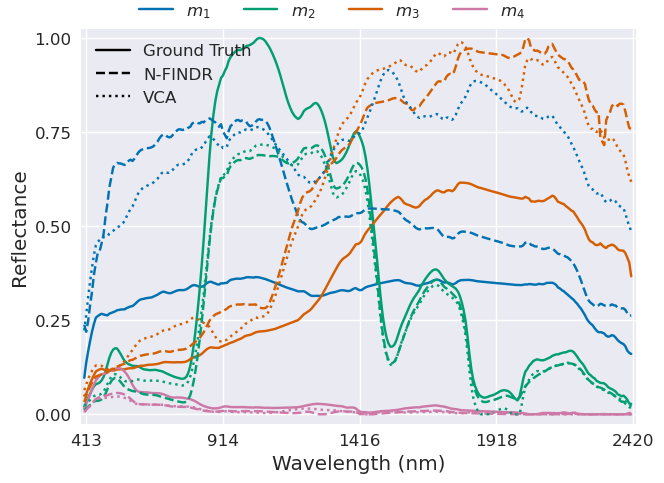

In [8]:
fig = plot_endmembers(dataset.endmembers() / dataset.endmembers().max(), dataset.wv, ticks_range=(0, 1), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_estimation.pdf'), bbox_inches='tight')

In [9]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

# Training

In [11]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=.1)
_ = model(dataset.X)
print(model.sparse_gate.regularize())
# train(model, n_endmembers, dataset, n_batchs=100, n_epochs=100, lr=1e-3, similarity_weight=1, sparse_weight=.1)
train(model, n_endmembers, dataset, n_batchs=100, n_epochs=100, lr=1e-3, similarity_weight=1, sparse_weight=0)

tensor(0.9971, grad_fn=<MeanBackward0>)


  0%|          | 0/100 [00:00<?, ?epoch/s, tls=-1.0000]

In [12]:
# model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=.1)
model.eval()
z = model.encoder(dataset.X.cuda())
model.sparse_gate(z).mean()

tensor(0.7468, device='cuda:0', grad_fn=<MeanBackward0>)

In [13]:
model.eval()
_ = model(dataset.X.cuda())
print(model.sparse_gate.variational_parameter().flatten())
print(model.sparse_gate.variational_parameter().flatten().mean())
print(model.sparse_gate.variational_parameter().flatten().min())
print(model.sparse_gate.regularize())

tensor([0.1070, 0.1086, 0.1069,  ..., 0.9903, 0.9984, 0.9997], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor(0.7468, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0896, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.8524, device='cuda:0', grad_fn=<MeanBackward0>)


# Save Model

In [14]:
# torch.save(model.state_dict(), os.path.join(result_path, 'clhu/weights/clhu.pth'))

# Testing model

In [15]:
# from HySpecLab.unmixing import ContrastiveUnmixing

# # load model
# model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

# model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/weights/clhu.pth')))
model = model.eval()

In [16]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

model.eval()
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [17]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(model.ebk).cpu())
        #  similarity_reg(sigmoid(model.ebk)).cpu())
    

tensor(0.0760) tensor(0.5234) tensor(8178.0254) tensor(0.0003)


In [18]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(3970.2573), tensor(0.0170))

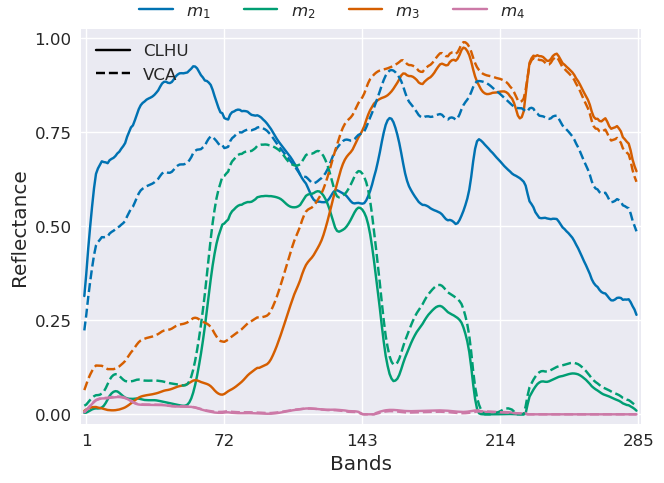

In [19]:
ebk = torch.sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
# fig = plot_endmembers(ebk, ticks_range=(0, 1))

plt.show(fig)
# fig.savefig(os.path.join(result_path, f'clhu/imgs/M_clhu_{endmember_init_method}.pdf'), bbox_inches='tight')

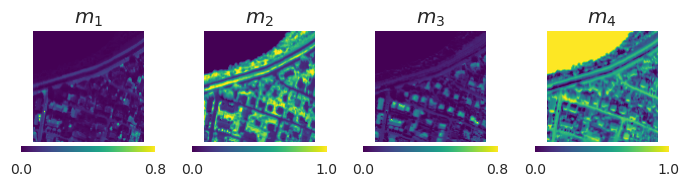

In [20]:
from torch.nn.functional import softmax
 
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
plt.show(fig)

# fig.savefig(os.path.join(result_path, f'clhu/imgs/A_clhu_{endmember_init_method}.pdf'), bbox_inches='tight')

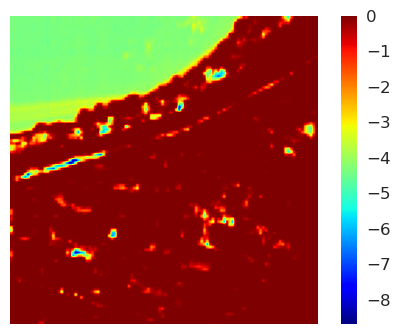

In [26]:
sparse = model.sparse_gate.variational_parameter().detach().cpu().numpy().reshape(dataset.n_row, dataset.n_col)
sparse = np.log(sparse)
fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(sparse.T, cmap='jet')
cbar = plt.colorbar(im)
# increase ticks font size in the colorbar
cbar.ax.tick_params(labelsize=12)
# cbar.set_label(r'$\log(\rho)$', labelpad=2, fontsize=14)
plt.axis('off')
plt.savefig(os.path.join(result_path, f'clhu/imgs/sparse_clhu_estimation_{endmember_init_method}.pdf'), bbox_inches='tight')
plt.show(fig)
plt.close(fig)

In [21]:
from HySpecLab.metrics import rmse, sad

X_true = dataset.A @ dataset.endmembers()
# X_true = dataset.X
X_hat = model(dataset.X).detach().cpu()
A_hat = torch.softmax(model.A.detach().cpu(), dim=1)
M_hat = sigmoid(model.ebk.detach().cpu())

_M_hat = model(M_hat).detach().cpu()

import pandas as pd
df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
df['Method'] = ['CLHU']
df['RMSE_X'] = [rmse(X_true, X_hat, dim=None).numpy()]
df['RMSE_A'] = [rmse(dataset.A, A_hat, dim=None).numpy()]

# sad_result = sad(M_hat, dataset.endmembers()).numpy()
sad_result = sad(_M_hat, dataset.endmembers()).numpy()

df['SAD_M'] = np.diagonal(sad_result).mean()

# df.to_csv(os.path.join(result_path, 'clhu/metrics.csv'), index=False)
df

,Method,RMSE_X,RMSE_A,SAD_M
0,CLHU,0.06258532,0.23966669,0.158273


In [22]:
import pandas as pd
M_hat = sigmoid(model.ebk.detach().cpu())
real_M_hat = model(M_hat).detach().cpu()
real_M_hat2 = model(real_M_hat).detach()

sad_M = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
sad_M_hat = np.diagonal(sad(real_M_hat, dataset.endmembers()).numpy()).mean()
sad_M_hat2 = np.diagonal(sad(real_M_hat2, dataset.endmembers()).numpy()).mean()

print(sad_M, sad_M_hat, sad_M_hat2)
sad_df = pd.DataFrame(columns=['SAD_M', 'SAD_M_hat', 'SAD_M_hat2'])
sad_df['SAD_M'] = [sad_M]
sad_df['SAD_M_hat'] = [sad_M_hat]
sad_df['SAD_M_hat2'] = [sad_M_hat2]
sad_df.to_csv('/media/abian/Extreme SSD/Thesis/CLHU/review/EndmemberInsigth/apex_sad.csv', index=False)



0.17672202 0.15827289 0.15295655


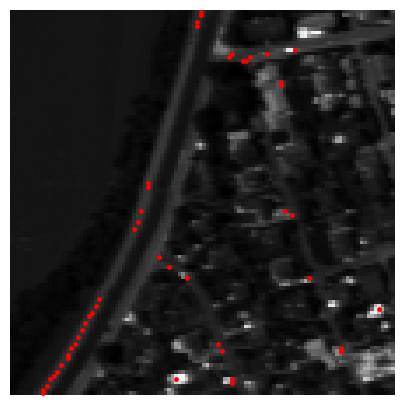

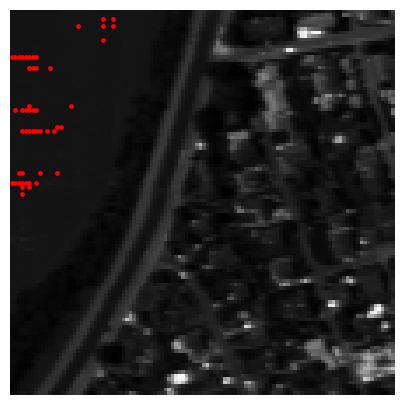

(50, 285) (50, 285)


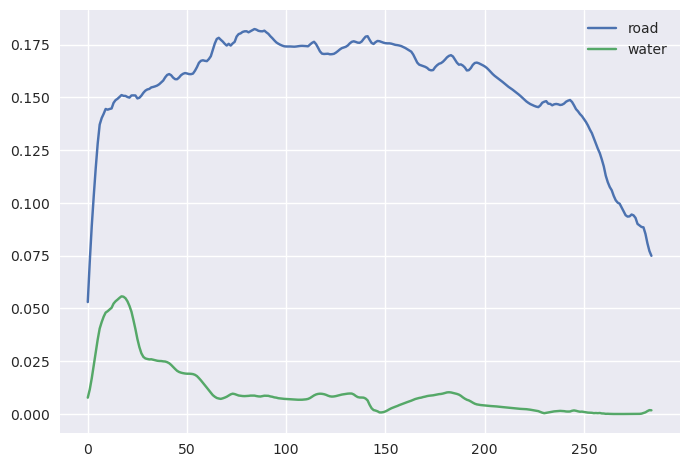

tensor(0.8785)

In [57]:
A_road = dataset.abundance()[:,:,0]
# find the coordinates of the 10 pixels with highest values
idx = np.unravel_index(np.argsort(A_road.ravel())[-50:], A_road.shape)
# plot the 10 pixels
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(dataset.image()[:,:, 10], cmap='gray')
ax.scatter(idx[1], idx[0], s=10, c='r')
ax.axis('off')  
plt.show()

A_water = dataset.abundance()[:,:,-1]
idx_water = np.unravel_index(np.argsort(A_water.ravel())[-50:], A_water.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(dataset.image()[:,:, 10], cmap='gray')
ax.scatter(idx_water[1], idx_water[0], s=10, c='r')
ax.axis('off')
plt.show()


signal_road = dataset.image()[idx[0], idx[1], :]
signal_water = dataset.image()[idx_water[0], idx_water[1], :]

print(signal_road.shape, signal_water.shape)
plt.plot(signal_road.mean(axis=0), label='road')
plt.plot(signal_water.mean(axis=0), label='water')
plt.legend()
plt.show()

# compute sad between signal_road mean and signal_water mean
from HySpecLab.metrics import sad
sad(torch.tensor(signal_road.mean(axis=0)).reshape(1,-1), torch.tensor(signal_water.mean(axis=0)).reshape(1,-1))


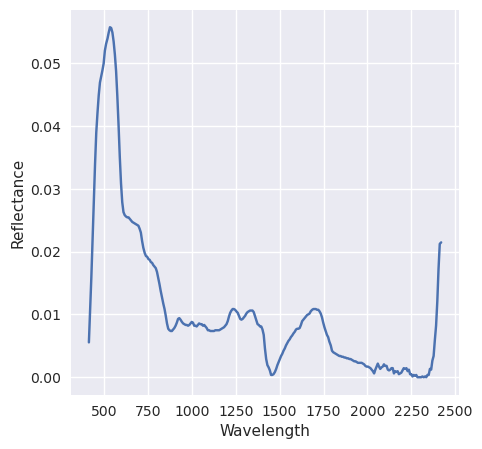

In [58]:
#plot the signal of the water
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(dataset.wv, dataset.image()[0, 0, :].T)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Reflectance')
plt.show()



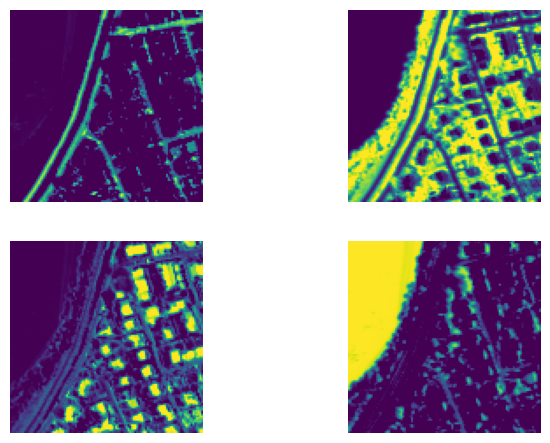

In [59]:
dataset = Apex('/home/abian/Data/Dataset/HSI/Apex/')
A = dataset.abundance()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(A[:,:,i], cmap='viridis')
    plt.axis('off')
plt.show()



# ...

In [60]:
from HySpecLab.metrics import rmse
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk).detach()
        _M_hat = model(M_hat).detach().cpu()
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    sad_m_2 = np.diagonal(sad(_M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m, sad_m_2

In [61]:
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=.5)
    train(model, n_endmembers, dataset, n_batchs=100, n_epochs=100, lr=1e-3, similarity_weight=1, sparse_weight=0)

    rmse_x, rmse_a, sad_m, x = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

    print(rmse_x, rmse_a, sad_m, x)

100%|██████████| 100/100 [00:28<00:00,  3.52epoch/s, tls=0.5852]


0.06118140369653702 0.18051913380622864 0.24966133 0.22168082


100%|██████████| 100/100 [00:28<00:00,  3.55epoch/s, tls=0.5863]


0.05809684842824936 0.1860864907503128 0.2512573 0.23473361


100%|██████████| 100/100 [00:28<00:00,  3.54epoch/s, tls=0.6045]


0.058705948293209076 0.18379664421081543 0.25065398 0.24577694


100%|██████████| 100/100 [00:28<00:00,  3.47epoch/s, tls=0.5939]


0.05951673537492752 0.18189631402492523 0.24726856 0.2431635


100%|██████████| 100/100 [00:29<00:00,  3.42epoch/s, tls=0.5902]


0.06252966076135635 0.18451949954032898 0.2456389 0.24537422


100%|██████████| 100/100 [00:28<00:00,  3.46epoch/s, tls=0.6027]


0.062438271939754486 0.18034175038337708 0.24411581 0.21915336


100%|██████████| 100/100 [00:28<00:00,  3.47epoch/s, tls=0.6083]


0.06042167916893959 0.18359161913394928 0.23955616 0.21523467


100%|██████████| 100/100 [00:29<00:00,  3.45epoch/s, tls=0.5936]


0.06252937018871307 0.1791355013847351 0.24341327 0.24185891


100%|██████████| 100/100 [00:28<00:00,  3.47epoch/s, tls=0.5955]


0.062366463243961334 0.1817527413368225 0.24718292 0.24696434


100%|██████████| 100/100 [00:28<00:00,  3.47epoch/s, tls=0.5864]

0.05710209906101227 0.18550240993499756 0.25639385 0.24500984


In [62]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

(0.06048884801566601,
 0.002039987742957496,
 0.18271421045064926,
 0.002337956671212575,
 0.24751422,
 0.004745888989418745)

In [32]:
df.to_csv(os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method)), index=False)

In [ ]:
os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method))

In [ ]:
print(np.diagonal(sad(endmember_init, dataset.endmembers()).numpy()).mean())
print(np.diagonal(sad(sigmoid(model.ebk.detach()).cpu(), dataset.endmembers()).numpy()).mean())

In [ ]:
print(sad(sigmoid(model.ebk.detach()).cpu(), dataset.endmembers()))

print(sad(endmember_init, dataset.endmembers()))




In [ ]:
fig = plot_endmembers(sigmoid(model.ebk.detach()).cpu(), dataset.wv, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU', '$M_0$'])
plt.show(fig)

In [ ]:
sad(endmember_init, endmember_init)

In [ ]:
sad(sigmoid(model.ebk.detach()).cpu(), sigmoid(model.ebk.detach()).cpu())